In [1]:
import os

In [2]:
!pip install ultralytics

In [3]:
from ultralytics import YOLO

In [4]:
import random
import shutil

In [5]:

# Paths
image_dir = r"C:\Users\user\minor_project\merged_ppe_dataset\images"
label_dir = r"C:\Users\user\minor_project\merged_ppe_dataset\labels"

# Step 1: Shift existing class IDs (0–3) → (1–4)
print("Shifting existing class IDs by +1...")

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        full_path = os.path.join(label_dir, label_file)
        updated_lines = []
        with open(full_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        old_class = int(parts[0])
                        # Shift only if in range 0-3
                        if 0 <= old_class <= 3:
                            new_class = old_class + 1
                            updated_line = " ".join([str(new_class)] + parts[1:])
                            updated_lines.append(updated_line)
                        else:
                            # Keep any other classes unchanged (if any)
                            updated_lines.append(line.strip())
                    except ValueError:
                        print(f"Skipping invalid line in {label_file}: {line.strip()}")
                else:
                    print(f"Skipping malformed line in {label_file}: {line.strip()}")
        # Overwrite file with shifted class IDs
        with open(full_path, "w") as f:
            for updated_line in updated_lines:
                f.write(updated_line + "\n")

print("Class IDs shifted successfully.")

# Step 2: Detect persons and add as class 0 (without duplicates)
print("Running person detection and updating labels...")

person_model = YOLO("yolov8n.pt")  # COCO pretrained weights, person class = 0

for image_file in os.listdir(image_dir):
    if image_file.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(image_dir, image_file)
        label_name = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_name)

        # Read existing labels if present
        existing_labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        try:
                            cls = int(parts[0])
                            # Exclude any existing person (class 0) labels to avoid duplicates
                            if cls != 0:
                                existing_labels.append(line.strip())
                        except ValueError:
                            pass

        # Run person detection
        results = person_model(image_path, conf=0.3)

        # Collect new person labels
        person_labels = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    cls = int(box.cls.item())
                    if cls == 0:  # person
                        x_center, y_center, w, h = box.xywhn[0].tolist()
                        person_labels.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        # Write combined labels (existing non-person + new person labels)
        with open(label_path, "w") as f:
            for label_line in existing_labels:
                f.write(label_line + "\n")
            for person_label in person_labels:
                f.write(person_label + "\n")

print("Person detection and labeling complete.")


Shifting existing class IDs by +1...
Class IDs shifted successfully.
Running person detection and updating labels...


100%|██████████| 6.25M/6.25M [00:00<00:00, 12.5MB/s]



image 1/1 C:\Users\user\minor_project\merged_ppe_dataset\images\000001_jpg.rf.6e6165c5c8395f28e2cea4162fb46612.jpg: 640x640 3 persons, 34.9ms
Speed: 6.3ms preprocess, 34.9ms inference, 230.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\user\minor_project\merged_ppe_dataset\images\000002_jpg.rf.1cd20249d94596f873dc8b24781250ef.jpg: 640x640 2 persons, 36.5ms
Speed: 4.8ms preprocess, 36.5ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\user\minor_project\merged_ppe_dataset\images\000003_jpg.rf.41522eef8f93fc082659195e0730b542.jpg: 640x640 4 persons, 1 truck, 1 horse, 39.4ms
Speed: 6.2ms preprocess, 39.4ms inference, 16.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\user\minor_project\merged_ppe_dataset\images\000004_jpg.rf.93e8f031df4e00fc4ce3a66869747cf4.jpg: 640x640 8 persons, 37.4ms
Speed: 8.1ms preprocess, 37.4ms inference, 14.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Use

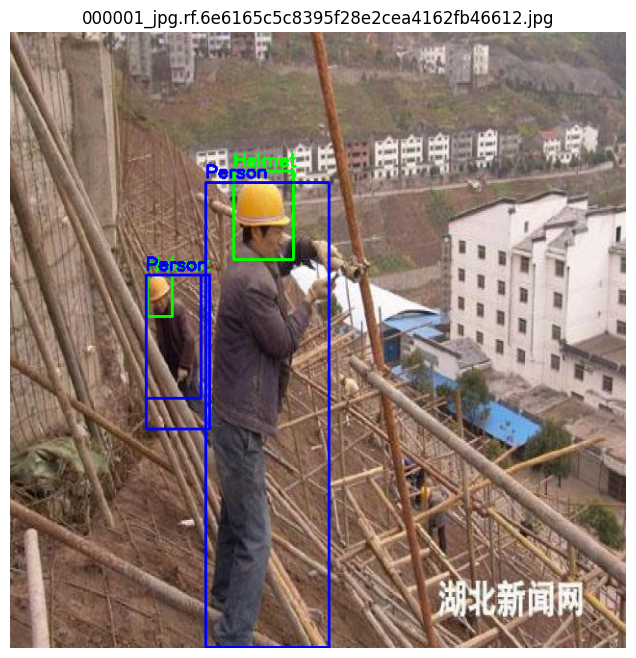

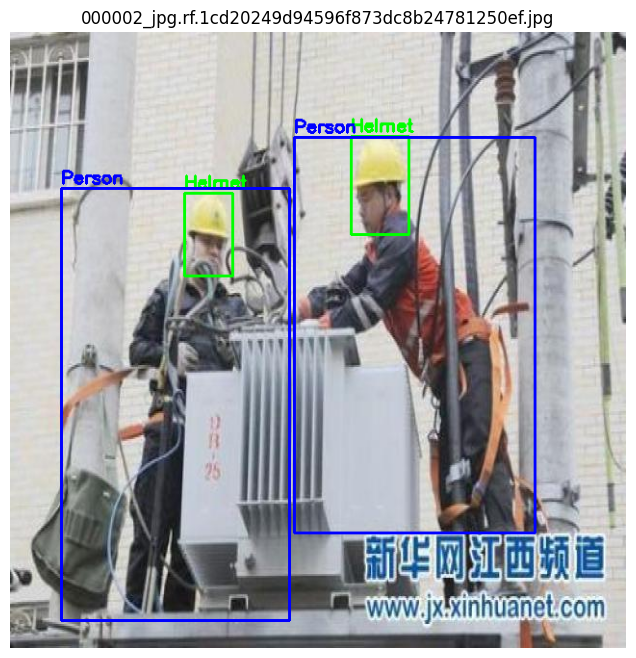

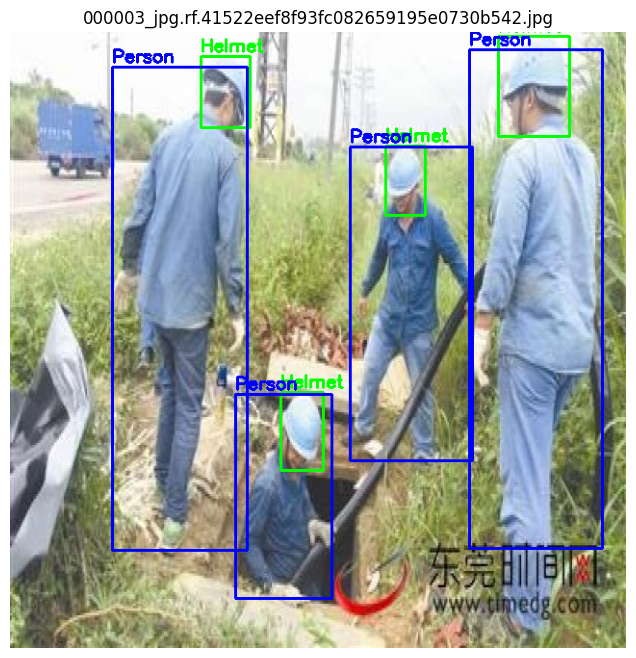

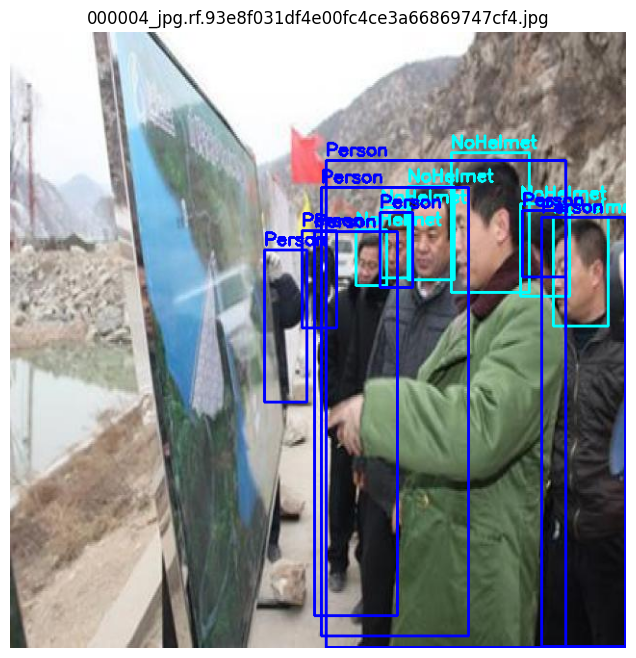

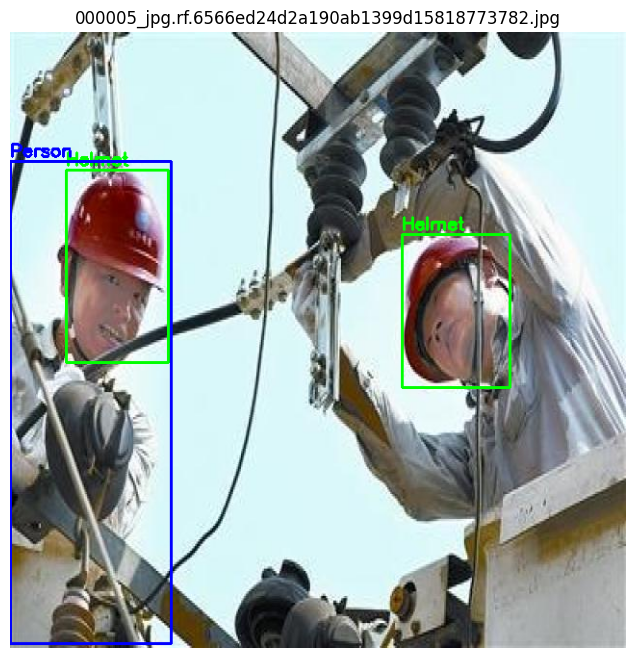

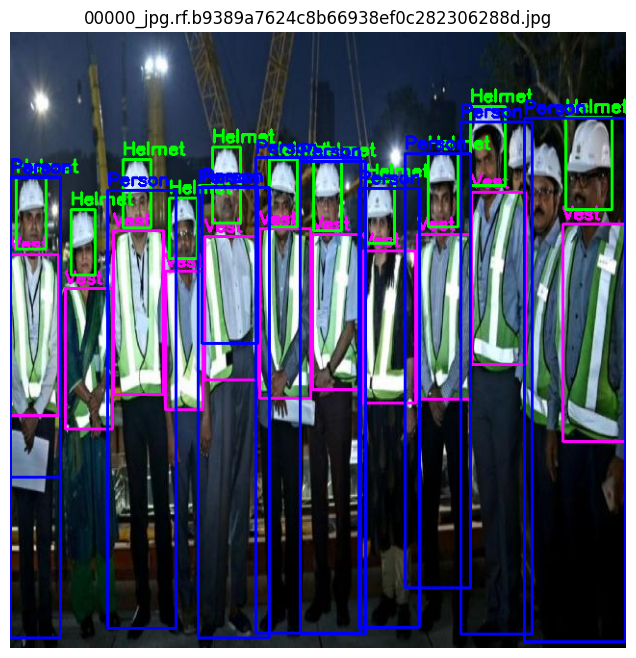

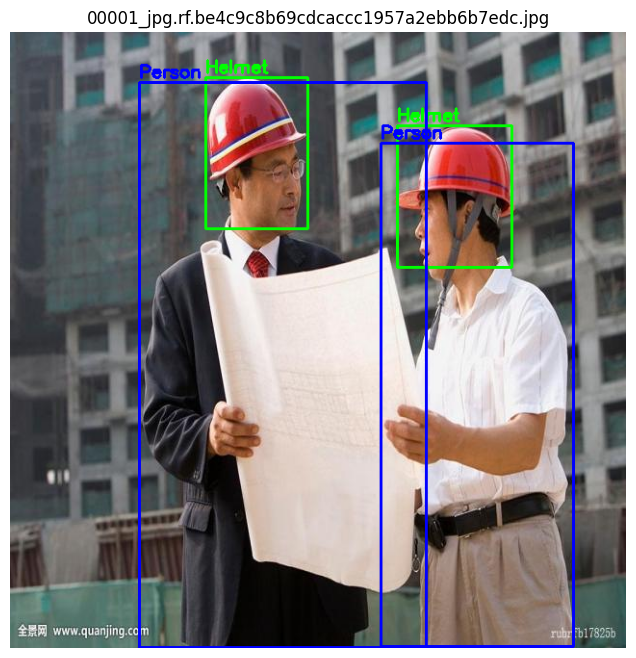

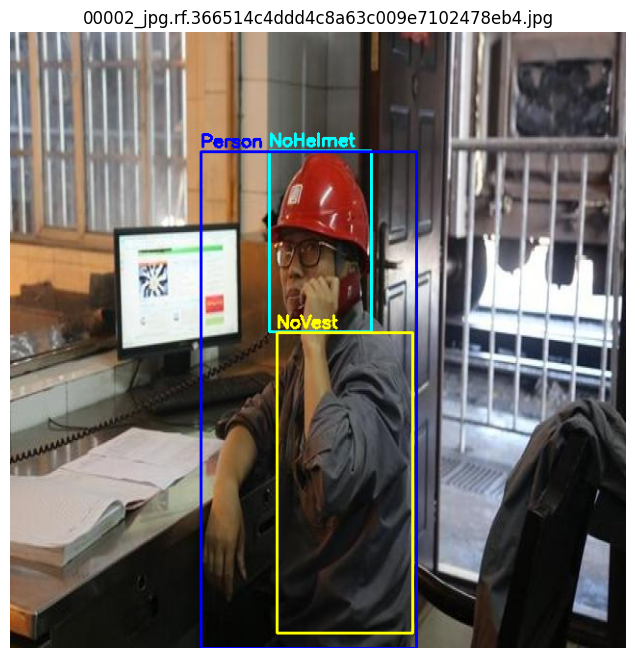

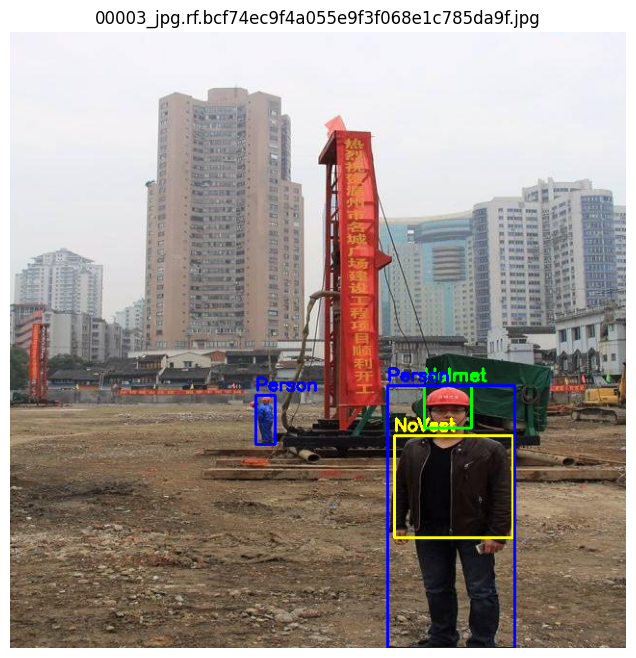

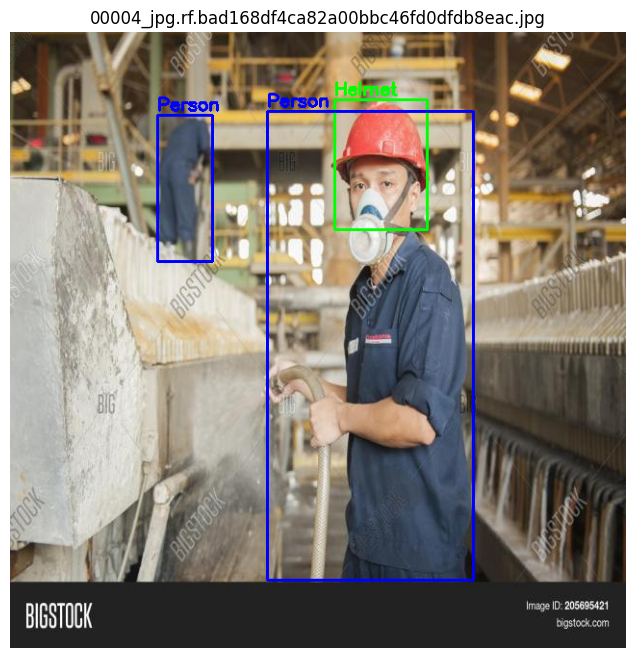

Saved annotated images to: C:\Users\user\minor_project\annotated_images


In [11]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
image_dir = r"C:\Users\user\minor_project\merged_ppe_dataset\images"
label_dir = r"C:\Users\user\minor_project\merged_ppe_dataset\labels"
output_dir = r"C:\Users\user\minor_project\annotated_images"

# Make sure output folder exists
os.makedirs(output_dir, exist_ok=True)

# Class names (0: Person, 1: Helmet, 2: NoHelmet, 3: NoVest, 4: Vest)
class_names = ['Person', 'Helmet', 'NoHelmet', 'NoVest', 'Vest']
colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]

# Pick a few images to check
sample_images = os.listdir(image_dir)[:10]  # adjust number as needed

for img_file in sample_images:
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + ".txt")

    # Read image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read image: {img_path}")
        continue
    h, w, _ = image.shape

    # Read label file
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                try:
                    class_id = int(parts[0])
                    if class_id < 0 or class_id >= len(class_names):
                        print(f"Invalid class ID {class_id} in {label_path}")
                        continue

                    x_center, y_center, box_w, box_h = map(float, parts[1:])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)

                    # Draw box and label
                    color = colors[class_id]
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(image, class_names[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                except ValueError:
                    print(f"Skipping invalid line in {label_path}: {line.strip()}")

    # Save annotated image
    save_path = os.path.join(output_dir, img_file)
    cv2.imwrite(save_path, image)

    # Show image
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title(img_file)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying image {img_file}: {e}")

print(f"Saved annotated images to: {output_dir}")


In [12]:
import os
from collections import defaultdict

# Path to your labels folder
label_dir = r"C:\Users\user\minor_project\merged_ppe_dataset\labels"

# Initialize class count dictionary
class_counts = defaultdict(int)

# Count instances of each class
for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1:
                    try:
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
                    except ValueError:
                        print(f"Invalid line in {label_file}: {line.strip()}")

# Class names (adjust if different)
class_names = ['Person', 'Helmet', 'NoHelmet', 'NoVest', 'Vest']

# Print results
print("Class Distribution:")
for class_id in sorted(class_counts.keys()):
    name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
    print(f"{class_id}: {name} — {class_counts[class_id]} instances")


Class Distribution:
0: Person — 10770 instances
1: Helmet — 3243 instances
2: NoHelmet — 2028 instances
3: NoVest — 1550 instances
4: Vest — 2054 instances


In [19]:

# Base directories
base_dir = r"C:\Users\user\minor_project\merged_ppe_dataset"
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Folders for splits
train_img_dir = os.path.join(image_dir, "train")
val_img_dir = os.path.join(image_dir, "val")
test_img_dir = os.path.join(image_dir, "test")

train_lbl_dir = os.path.join(label_dir, "train")
val_lbl_dir = os.path.join(label_dir, "val")
test_lbl_dir = os.path.join(label_dir, "test")

# Create folders if they don't exist (no deletion)
for folder in [train_img_dir, val_img_dir, test_img_dir,
               train_lbl_dir, val_lbl_dir, test_lbl_dir]:
    os.makedirs(folder, exist_ok=True)
    print(f"Ensured folder exists: {folder}")

# List all images in the original images folder (excluding train/val/test folders)
all_images = [f for f in os.listdir(image_dir)
              if f.endswith((".jpg", ".png",".jpeg")) and
              f not in os.listdir(train_img_dir) + os.listdir(val_img_dir) + os.listdir(test_img_dir)]

random.shuffle(all_images)

total = len(all_images)
train_end = int(total * 0.8)
val_end = train_end + int(total * 0.1)

train_images = all_images[:train_end]
val_images = all_images[train_end:val_end]
test_images = all_images[val_end:]

def copy_files(img_list, img_src_dir, img_dst_dir, lbl_src_dir, lbl_dst_dir):
    for img_file in img_list:
        lbl_file = os.path.splitext(img_file)[0] + ".txt"
        shutil.copy(os.path.join(img_src_dir, img_file), img_dst_dir)
        shutil.copy(os.path.join(lbl_src_dir, lbl_file), lbl_dst_dir)

# Copy images and labels
copy_files(train_images, image_dir, train_img_dir, label_dir, train_lbl_dir)
copy_files(val_images, image_dir, val_img_dir, label_dir, val_lbl_dir)
copy_files(test_images, image_dir, test_img_dir, label_dir, test_lbl_dir)

print(f" Dataset re-split complete:")
print(f"Train: {len(train_images)} images")
print(f"Val: {len(val_images)} images")
print(f"Test: {len(test_images)} images")


Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\images\train
Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\images\val
Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\images\test
Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\labels\train
Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\labels\val
Ensured folder exists: C:\Users\user\minor_project\merged_ppe_dataset\labels\test
 Dataset re-split complete:
Train: 2569 images
Val: 321 images
Test: 322 images


In [22]:


base_dir = r"C:\Users\user\minor_project\merged_ppe_dataset"
image_dir = os.path.join(base_dir, "images")

all_images_dir = os.path.join(base_dir, "all_images")
os.makedirs(all_images_dir, exist_ok=True)

subfolders = ['train', 'val', 'test']

for subfolder in subfolders:
    subfolder_path = os.path.join(image_dir, subfolder)
    if os.path.exists(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            if file_name.lower().endswith(('.jpg', '.png')):
                src_path = os.path.join(subfolder_path, file_name)
                dst_path = os.path.join(all_images_dir, file_name)
                if not os.path.exists(dst_path):
                    shutil.copy2(src_path, dst_path)  # or shutil.move if you want to move instead of copy
print(" All images copied to all_images folder")


 All images copied to all_images folder


In [23]:
label_dir = os.path.join(base_dir, "labels")
all_labels_dir = os.path.join(base_dir, "all_labels")
os.makedirs(all_labels_dir, exist_ok=True)

for subfolder in subfolders:
    subfolder_path = os.path.join(label_dir, subfolder)
    if os.path.exists(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            if file_name.lower().endswith('.txt'):
                src_path = os.path.join(subfolder_path, file_name)
                dst_path = os.path.join(all_labels_dir, file_name)
                if not os.path.exists(dst_path):
                    shutil.copy2(src_path, dst_path)
print(" All labels copied to all_labels folder")


 All labels copied to all_labels folder


In [24]:
# Use these folders as your raw data source
raw_image_dir = os.path.join(base_dir, "all_images")
raw_label_dir = os.path.join(base_dir, "all_labels")

# Define split folders (create them outside raw folders)
train_img_dir = os.path.join(base_dir, "train", "images")
val_img_dir = os.path.join(base_dir, "val", "images")
test_img_dir = os.path.join(base_dir, "test", "images")

train_lbl_dir = os.path.join(base_dir, "train", "labels")
val_lbl_dir = os.path.join(base_dir, "val", "labels")
test_lbl_dir = os.path.join(base_dir, "test", "labels")

# Make sure split folders exist
for folder in [train_img_dir, val_img_dir, test_img_dir,
               train_lbl_dir, val_lbl_dir, test_lbl_dir]:
    os.makedirs(folder, exist_ok=True)

# List all images from all_images folder
all_images = [f for f in os.listdir(raw_image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'))]

import random
random.shuffle(all_images)

total = len(all_images)
train_end = int(0.8 * total)
val_end = train_end + int(0.1 * total)

train_images = all_images[:train_end]
val_images = all_images[train_end:val_end]
test_images = all_images[val_end:]

def copy_files(img_list, img_src_dir, img_dst_dir, lbl_src_dir, lbl_dst_dir):
    for img_file in img_list:
        lbl_file = os.path.splitext(img_file)[0] + ".txt"
        shutil.copy2(os.path.join(img_src_dir, img_file), img_dst_dir)
        shutil.copy2(os.path.join(lbl_src_dir, lbl_file), lbl_dst_dir)

copy_files(train_images, raw_image_dir, train_img_dir, raw_label_dir, train_lbl_dir)
copy_files(val_images, raw_image_dir, val_img_dir, raw_label_dir, val_lbl_dir)
copy_files(test_images, raw_image_dir, test_img_dir, raw_label_dir, test_lbl_dir)

print(" Dataset split done!")
print(f"Train: {len(train_images)} images")
print(f"Val: {len(val_images)} images")
print(f"Test: {len(test_images)} images")


 Dataset split done!
Train: 2569 images
Val: 321 images
Test: 322 images
